In [3]:
include("CGS_POMDP.jl");
pomdp = CGSPOMDP();


In [ ]:
AbstractGPs
AbstractGPsMakie
CairoMakie
DataFrames
DataStructures
Distributions
GLMakie
GeoStats
GeoStatsFunctions
GeoStatsModels
Infiltrator
POMCPOW
POMDPModelTools
POMDPModels
POMDPSimulators
POMDPs
Plots
Unitful

10000-element Vector{Point{𝔼{2}, Cartesian2D{NoDatum, Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}}}:
 Point(x: 0.0 m, y: 0.0 m)
 Point(x: 1.0 m, y: 0.0 m)
 Point(x: 2.0 m, y: 0.0 m)
 Point(x: 3.0 m, y: 0.0 m)
 Point(x: 4.0 m, y: 0.0 m)
 Point(x: 5.0 m, y: 0.0 m)
 Point(x: 6.0 m, y: 0.0 m)
 Point(x: 7.0 m, y: 0.0 m)
 Point(x: 8.0 m, y: 0.0 m)
 Point(x: 9.0 m, y: 0.0 m)
 ⋮
 Point(x: 91.0 m, y: 99.0 m)
 Point(x: 92.0 m, y: 99.0 m)
 Point(x: 93.0 m, y: 99.0 m)
 Point(x: 94.0 m, y: 99.0 m)
 Point(x: 95.0 m, y: 99.0 m)
 Point(x: 96.0 m, y: 99.0 m)
 Point(x: 97.0 m, y: 99.0 m)
 Point(x: 98.0 m, y: 99.0 m)
 Point(x: 99.0 m, y: 99.0 m)

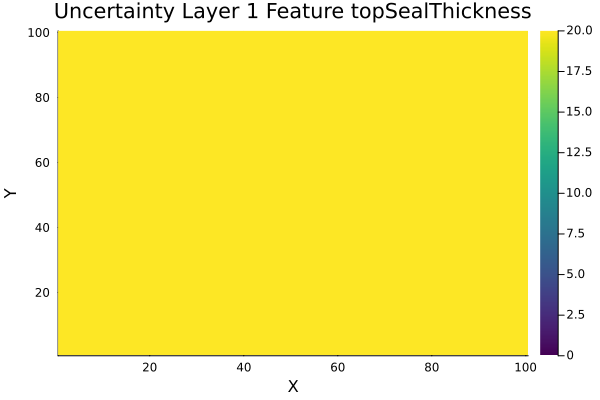

In [ ]:
visualize_uncertainty(pomdp, 1, :topSealThickness)

In [ ]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [28]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

In [29]:
POMDPs.observation(pomdp, all_actions[2], pomdp.state)

Distributions.ProductDistribution{2, 1, Vector{FullNormal}, Distributions.Continuous, Float64}(
dists: FullNormal[FullNormal(
dim: 1
μ: [0.5342679264220465]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [378.83615385892375]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [21.40121350719524]
Σ: [0.04999375078114099;;]
)
, FullNormal(
dim: 1
μ: [300.6110852162784]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [16.83946251913136]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [35.600220136452805]
Σ: [0.04999375078114099;;]
)
, FullNormal(
dim: 1
μ: [1050.9866816673457]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [2.3636672537295453]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [44.93517324289125]
Σ: [0.04999375078114099;;]
)
, FullNormal(
dim: 1
μ: [1566.6489017159272]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [261.231470751243]
Σ: [0.04999997222330421;;]
)
, FullNormal(
dim: 1
μ: [79.26309301791326]
Σ: [0.04999375078114099;;]
)
, FullN

In [30]:
POMDPs.reward(pomdp, pomdp.state, all_actions[2])

  0.000000 seconds
action_cost -3
  0.214103 seconds (696.46 k allocations: 57.215 MiB, 34.83% gc time, 58.91% compilation time)
information_gain: 1.0
  6.165467 seconds (266.45 M allocations: 10.345 GiB, 12.56% gc time, 5.34% compilation time)
reward_suitability: 14566.600000005123


14564.600000005123

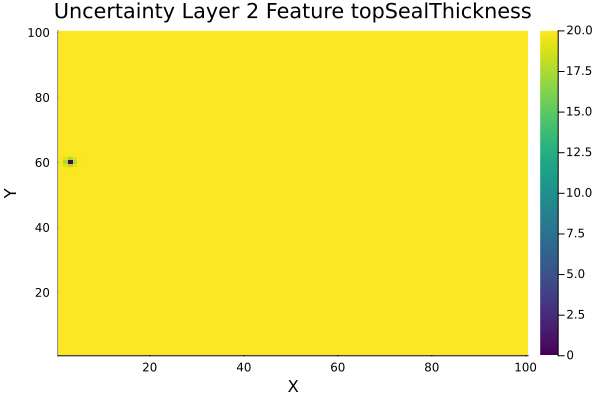

In [31]:
visualize_uncertainty(pomdp, 2, :topSealThickness)

In [32]:
POMDPs.observation(pomdp, all_actions[21], pomdp.state) # Can take up to 7 mins to run!

Distributions.ProductDistribution{2, 1, Vector{FullNormal}, Distributions.Continuous, Float64}(
dists: FullNormal[FullNormal(
dim: 25
μ: [4.373064484126303, 3.1852339653523245, 3.3712583341902587, 2.578821934050893, 1.452053688859678, 1.314311409805839, -0.6058445498077845, -0.24417848749919813, -1.9761928504524349, 0.365392195054028  …  -1.8911468136161602, -1.5247938921137347, -1.5822899528152448, -2.1306006986102943, -1.1623695456135579, 1.5458176963185792, 1.1139525710763678, 1.3969687584238955, 3.014380962287646, 1.8636509054230714]
Σ: [0.4999972189834807 9.542463885736652e-8 … 1.138967642679961e-43 -2.6457661960880744e-45; 9.542463885736652e-8 0.4999972157238517 … -4.903106302490507e-42 1.138967642729764e-43; … ; 1.138967642679961e-43 -4.903106302490507e-42 … 0.4999972157092998 9.542463885736652e-8; -2.6457661960880744e-45 1.138967642729764e-43 … 9.542463885736652e-8 0.4999972189834807]
)
, FullNormal(
dim: 25
μ: [379.9150384809059, 380.8747946449144, 378.3938518862391, 376.75539

In [33]:
POMDPs.reward(pomdp, pomdp.state, all_actions[21])

  0.000000 seconds
action_cost -4
  0.068464 seconds (300.86 k allocations: 151.084 MiB, 18.23% gc time)
information_gain: 110080.61471245438
  8.962611 seconds (265.25 M allocations: 15.650 GiB, 12.03% gc time)
reward_suitability: 14864.400000005395


124941.01471245977

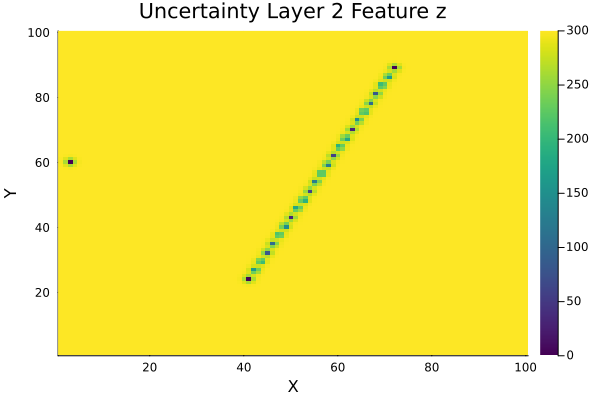

In [34]:
visualize_uncertainty(pomdp, 2, :z)

### Test: Points close are predicted with more accuracy and less uncertainty than points far.

In [8]:
gtlayer = pomdp.state.earth[1].gt

# seismic_line = (x1=0.0, y1=0.0, x2=5.0, y2=98.0)
well1 = Point(19, 34)
well2 = Point(30, 12)
well_close = Point(31, 14)
well_far = Point(98, 97)

all_wells = Multi([well1, well2])
data_at_all_wells = gtlayer[all_wells, :]

γ = SphericalVariogram(range=RANGE, sill=SILL, nugget=NUGGET)

okrig = GeoStatsModels.OrdinaryKriging(γ)
fitkrig = GeoStatsModels.fit(okrig, data_at_all_wells)

# We notice that prediction at close has much less variance than prediction at far, 
# and as an additional sanity check the prediction at close is close to the well2 point.
# Krigging predictprob only does one attribute at a time.

probs_far = GeoStatsModels.predictprob(fitkrig, :z, well_far)
probs_close = GeoStatsModels.predictprob(fitkrig, :z, well_close)
probs_close, probs_far

UndefVarError: UndefVarError: `pomdp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Test: Uncertainty is low around known points.
Additionally, as nugget is increased uncertainty (both globally and at known points) increases.
Pay attention to colorbar when verifying this.

### Buy well data at 3-4 locations and visualize belief

In [10]:
buy_well_data(pomdp, 2)
buy_well_data(pomdp, 5)
buy_well_data(pomdp, 7)

UndefVarError: UndefVarError: `pomdp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
visualize_uncertainty(Multi([pomdp.collected_locs...]), 3, "z") # Note this is time consuming at just 3 gathered points.

UndefVarError: UndefVarError: `pomdp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
distr = observe(pomdp, Point(18, 24), 3, "z")
rand(distr)

UndefVarError: UndefVarError: `pomdp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.